In [1]:
import string, re, json, pickle, warnings, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from data_preparation import take_a_shower, clean_content_aravec
from utils import *

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)

In [3]:
data = pd.read_csv('./data/offensive_dataset.csv', encoding="utf-16")
data.head()

,Comment,is_off
0,شوف حد ين*** أنت و إيران.,1
1,شوف تيفي قوداتها مع الجن غي بلاتي يجي من مكة,0
2,عجب يتفاوظون على شعوب عربية وعليهم وهىلا تعلم,0
3,ههههههه هاد شوف تيفي اللي حطت عليه مشا فيها,0
4,الرزق يأتي من حيث لا تدري 🙌🏻❤️,0


<AxesSubplot:xlabel='is_off', ylabel='count'>

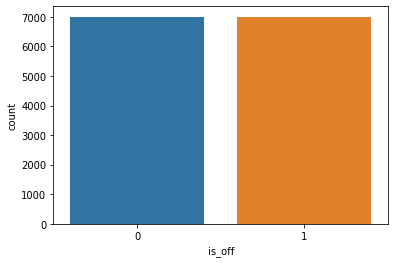

In [4]:
sns.countplot(x='is_off', data=data)

In [5]:
data.Comment = data.Comment.apply(take_a_shower)
data.shape

(14000, 2)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  14000 non-null  object
 1   is_off   14000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 218.9+ KB


In [7]:
data.head()

,Comment,is_off
0,شوف حد ايران,1
1,شوف تيفي قوداتها الجن غي بلاتي يجي مكه,0
2,عجب يتفاوظون شعوب عربيه وعليهم وهيلا تعلم,0
3,هه هاد شوف تيفي اللي حطت مشا,0
4,الرزق ياتي تدري 🙌🏻❤️,0


# AraVec Embedding

In [8]:
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.initializers import glorot_uniform
from sklearn.preprocessing import LabelEncoder
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.callbacks import Callback
from keras.utils import np_utils
import gensim

In [63]:
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100 #176 # based on our inputs; TODO: remove outliers? dynamically calculate!
EMBEDDING_DIM = 100 # w2v, fastText; GloVe=50

In [65]:
path = './bin/aravec/tweets_sg_100'
WORD_MODEL, _, MAX_FEATURES, EMBED_SIZE = get_init_parameters(path)

In [132]:
print(MAX_FEATURES)
print(EMBED_SIZE)

331679
100


In [67]:
# load data
x = data.Comment.values
y = data.is_off.values
MAX_TEXT_LENGTH = get_max_length(x)
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print('Dataset splited.')
CLASSES_LIST = np.unique(y)
print('Label categories: ' + str(CLASSES_LIST))
print("Max Length: " + str(MAX_TEXT_LENGTH))

Dataset splited.
Label categories: [0 1]
Max Length: 461


In [68]:
# Sequence length
print("Original sequence length : "+str(MAX_TEXT_LENGTH))

# CHANGE MAX LENGTH (timesteps)
MAX_TEXT_LENGTH = 100
# MAX_FEATURES = 10000

Original sequence length : 461


In [69]:
x_train, x_test, y_train, y_test, train_y_cat, word_index = class_str_2_ind(X_train, X_test, 
                                                                            Y_train, Y_test,
                                                                            CLASSES_LIST, MAX_FEATURES,
                                                                            MAX_TEXT_LENGTH)
test_cat_y = np_utils.to_categorical(y_test, len(CLASSES_LIST))

Converting data to trainable form...
Number of training examples: 11200
Number of testing examples: 2800


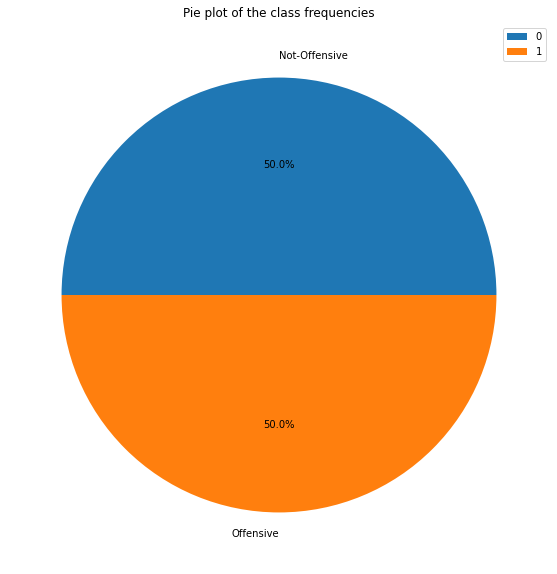

In [70]:
LABELS = (
    'Not-Offensive', 'Offensive'
)

tmp = np.concatenate((y_train, y_test))
unique, counts = np.unique(tmp, return_counts=True)
del tmp
plt.figure("Target Pie", figsize=(10, 10))
plt.title("Pie plot of the class frequencies")
plt.pie(counts, labels=LABELS, autopct='%1.1f%%')
plt.legend(unique)
# plt.savefig("./img/stats_classes.png")
plt.show();

In [124]:
def get_lstm_model(embedding_weights, word_index, vocab_dim, max_length, print_summary=True):
    """
    DOC
    """
#     inp = Input(shape=(max_length,))
#     model = Embedding(input_dim=len(word_index)+1,
#                       output_dim=vocab_dim,
#                       trainable=False,
#                       weights=[embedding_weights])(inp)
#     model = LSTM(units=32, return_sequences=True, return_state=False)(model)
#     model = Dropout(0.1)(model)
    
#     model = LSTM(units=16, return_sequences=True, return_state=False)(model)
#     model = Dropout(0.1)(model)
        
#     model = Flatten()(model)
        
#     model = Dense(200, activation='relu')(model)
#     model = Dropout(0.1)(model)
    
#     model = Dense(1, activation='sigmoid')(model)
#     model = Model(inputs=inp, outputs=model)

    """
    MAX_FEATURES: 331679
    MAX_TEXT_LENGTH: 100
    =========================
    Training Accuracy: 0.8969
    Training Loss: 0.2534
    =========================
    Testing Accuracy:  0.7900
    Testing Loss:  0.5070
    """    
    model = Sequential()
    model.add(Input(shape=(max_length,)))
    model.add(Embedding(input_dim=len(word_index)+1, 
                        output_dim=vocab_dim, 
                        trainable=False,
                        weights=[embedding_weights]))
    model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
    model.add(GlobalMaxPool1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    if print_summary:
        model.summary()
    return model

In [125]:
print("Parameters Values:")
print("word_index: ")
print(len(word_index))
print("WORD_MODEL: ")
print(WORD_MODEL)
print("EMBED_SIZE: ")
print(EMBED_SIZE)
print("MAX_TEXT_LENGTH: ")
print(MAX_TEXT_LENGTH)
print("\n")

embedding_matrix, words_not_found = get_embedding_matrix(word_index, WORD_MODEL, EMBED_SIZE)
print("\nBuild LSTM Model ...")
model = get_lstm_model(embedding_matrix, word_index, EMBED_SIZE, MAX_TEXT_LENGTH, print_summary=True)


Parameters Values:
word_index: 
44530
WORD_MODEL: 
EMBED_SIZE: 
100
MAX_TEXT_LENGTH: 
100


Building embedding matrix...
Embedding matrix built.

Build LSTM Model ...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 100, 100)          4453100   
_________________________________________________________________
lstm_11 (LSTM)               (None, 100, 32)           17024     
_________________________________________________________________
dropout_33 (Dropout)         (None, 100, 32)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 100, 16)           3136      
_________________________________________________________________
dropout_34 (Dropout)      

In [126]:
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 14818


In [84]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['محشمش' 'خاصر' 'وكتخرجي' 'طابونا' 'النصوصه' 'ادوزوا' 'وتتوبو' 'وكيلسقو'
 'وكيستر' 'حزيره']


In [76]:
def train_fit_predict(model, x_train, x_test, y_train, y_test, batch_size, epochs):
    """
    DOC 
    """
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)
    return history, model

In [127]:
history, model = train_fit_predict(model,
                               x_train,
                               x_test,
                               y_train, y_test,
                               batch_size=64, epochs=50)

Epoch 1/50
140/140 [==============================] - 5s 36ms/step - loss: 0.5871 - accuracy: 0.6884 - val_loss: 0.5592 - val_accuracy: 0.7201
Epoch 2/50
140/140 [==============================] - 5s 33ms/step - loss: 0.5245 - accuracy: 0.7358 - val_loss: 0.5390 - val_accuracy: 0.7366
Epoch 3/50
140/140 [==============================] - 5s 33ms/step - loss: 0.4940 - accuracy: 0.7571 - val_loss: 0.5406 - val_accuracy: 0.7326
Epoch 4/50
140/140 [==============================] - 5s 33ms/step - loss: 0.4769 - accuracy: 0.7650 - val_loss: 0.5234 - val_accuracy: 0.7469
Epoch 5/50
140/140 [==============================] - 5s 33ms/step - loss: 0.4559 - accuracy: 0.7820 - val_loss: 0.5152 - val_accuracy: 0.7366
Epoch 6/50
140/140 [==============================] - 5s 33ms/step - loss: 0.4374 - accuracy: 0.7876 - val_loss: 0.5118 - val_accuracy: 0.7558
Epoch 7/50
140/140 [==============================] - 5s 33ms/step - loss: 0.4135 - accuracy: 0.7955 - val_loss: 0.5317 - val_accuracy: 0.7496

In [128]:
loss, accuracy = model.evaluate(x_train, y_train)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))
loss_val, accuracy_val = model.evaluate(x_test, y_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy_val))
print("Testing Loss:  {:.4f}".format(loss_val))

350/350 [==============================] - 4s 10ms/step - loss: 0.4775 - accuracy: 0.9436
Training Accuracy: 0.9436
Training Loss: 0.4775
88/88 [==============================] - 1s 10ms/step - loss: 2.1430 - accuracy: 0.7543
Testing Accuracy:  0.7543
Testing Loss:  2.1430


In [129]:
y_pred = model.predict(x_test, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_pred = (y_pred > 0.5)

print(classification_report(y_test, y_pred))

88/88 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       0.75      0.76      0.75      1384
           1       0.76      0.75      0.76      1416

    accuracy                           0.75      2800
   macro avg       0.75      0.75      0.75      2800
weighted avg       0.75      0.75      0.75      2800



In [130]:
n = np.argmin(history.history['val_loss'])

print("Optimal epoch : {}".format(n))
print("Accuracy on train : {} %".format(np.round(history.history['accuracy'][n]*100, 2)))
print("Accuracy on test : {} %".format(np.round(history.history['val_accuracy'][n]*100, 2)))
print("Loss on train : {}".format(np.round(history.history['loss'][n]*100, 2)))
print("Loss on test : {}".format(np.round(history.history['val_loss'][n]*100, 2)))

Optimal epoch : 7
Accuracy on train : 80.61 %
Accuracy on test : 75.4 %
Loss on train : 39.88
Loss on test : 50.7


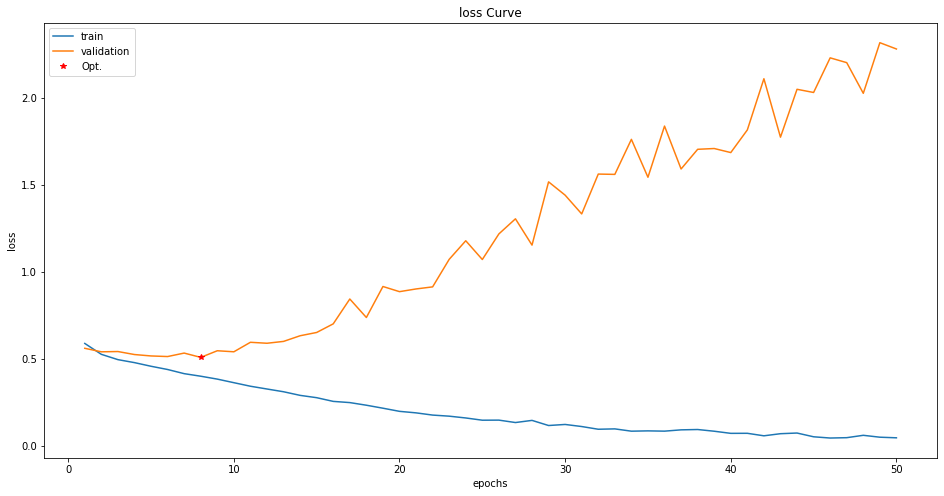

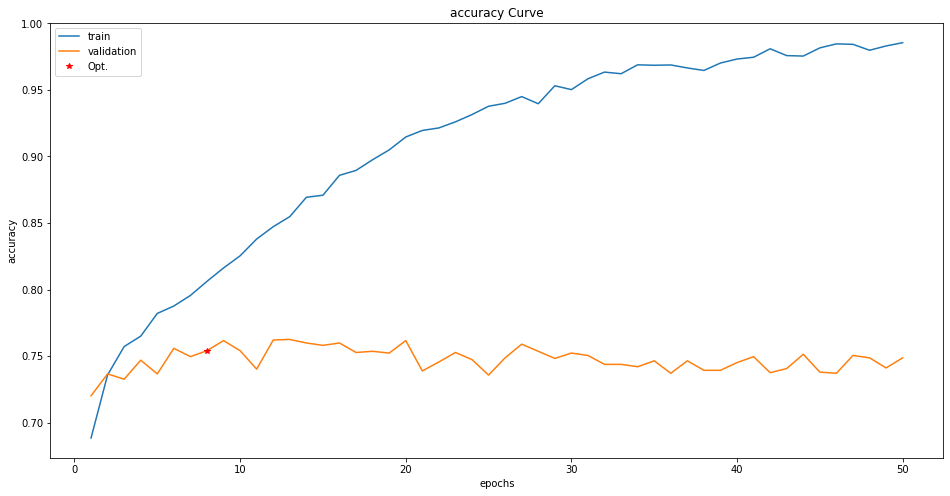

In [131]:
#train loss vs validation loss
show_train_history(history,'loss','val_loss', n)

show_train_history(history,'accuracy','val_accuracy', n)

In [115]:
pred_test = model.predict(x_test, verbose=True)

88/88 [==============================] - 2s 21ms/step


In [116]:
pred_test.shape[0]
df_blind = pd.DataFrame({'REAL': y_test, 
                         'PRED': pred_test.reshape(pred_test.shape[0],), 
                         'TEXT': X_test})
df_blind = df_blind.reset_index()[['REAL', 'PRED', 'TEXT']]
df_blind.PRED = df_blind.PRED.round()
error_records = df_blind[df_blind.REAL != df_blind.PRED]

In [117]:
print("Number of misclassified reviews: {} out of {}".format(error_records.shape[0], df_blind.shape[0]))
print("Blind Test Accuracy:  {:.4f}".format(accuracy_score(df_blind.REAL, df_blind.PRED)))

Number of misclassified reviews: 588 out of 2800
Blind Test Accuracy:  0.7900


In [105]:
df_blind

,REAL,PRED,TEXT
0,1,1.0,خسات نجس المملكه العربيه السعوديه الاسلاميه قو...
1,1,1.0,اسمع ياصحافي نيك يماك ناكت صليبي اكيد وجابتك م...
2,1,0.0,هه عيد ميلاد باللحم البرقوق والله شوف تيفي معن...
3,0,0.0,حياه انسان لحظه لاتعود الحياه بعدها قبلها
4,1,1.0,هاد القناه خاصكم الاعدام طلعت غي بالفضاءح ديال...
...,...,...,...
2795,1,1.0,الاحسن تستبدل اسمك مصراوي يهودي المصريون اناس ...
2796,1,1.0,كيتلوا بحال لفعه الله يعطك دقه جدي طاح ناد
2797,1,1.0,بنت لحرام ولات كتحطو بوجهو ميقول حد مفراسوش هه
2798,1,0.0,مقدم برنامج اكبرا قود لله حرقك انشاء لله


In [119]:
print('./models/aravec/lstm_acc_{}.json'.format(round(accuracy_val, 4)))

./models/aravec/lstm_acc_0.79.json


In [123]:
save_model('aravec', 'lstm', round(accuracy_val, 4))

In [122]:
def save_model(folder, name, acc):
    with open('./models/' + folder + '/' + name + '_acc_' + str(acc) + '.json', 'w') as f:
        f.write(model.to_json())
        f.close()

    model.save_weights('./models/' + folder + '/' + name + '_weights_acc_' + str(acc) + '.h5')

    model.save('./models/' + folder + '/' + name + '_acc_' + str(acc) + '.h5')

In [44]:
def show_train_history(history,train,validation, n):
    plt.figure(figsize=(16, 8))
    plt.plot(range(1, len(history.history[train])+1), history.history[train], label="train")
    plt.plot(range(1, len(history.history[validation])+1), history.history[validation], label="validation")
    plt.plot(n+1,history.history[validation][n],"r*", label="Opt.")
    plt.legend()
    plt.title(str(train) + " Curve")
    plt.ylabel(train)
    plt.xlabel("epochs")
    plt.show()